<a href="https://colab.research.google.com/github/aks2093/corona-Data-analysis-and-prediction/blob/master/timeSeries_model_death_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy
import numpy as np

data_dir = "/content/drive/My Drive/vumonic"
latest = os.path.join(data_dir, "07-12-2020.csv")
confirmed = os.path.join(data_dir, "time_series_covid19_confirmed_global.csv")
deaths = os.path.join(data_dir, "time_series_covid19_deaths_global.csv")
recovered = os.path.join(data_dir, "time_series_covid19_recovered_global.csv")
csse_daily = os.path.join(data_dir, "csse_daily.csv")
population = os.path.join(data_dir, "population_by_country_2020.csv") #data source: https://www.kaggle.com/tanuprabhu/population-by-country-2020

latest = pd.read_csv(latest)
confirmed = pd.read_csv(confirmed)
deaths = pd.read_csv(deaths)
recovered = pd.read_csv(recovered)
csse_daily = pd.read_csv(csse_daily)
population = pd.read_csv(population)
print("Data Import Done")

Data Import Done


**Approach:**
1. Here we are trying to predict daily increase in the death cases.
2. will keep last 7 days for forecast
3. we will skip the timeline 22nd-Jan to 15th-Feb for all countries except china, and train our time series model on data starting from 16th Feb.

In [2]:
excluded_columns = ['Province/State', 'Lat', 'Long']


required_death_word_wide_data = deaths.drop(excluded_columns, axis=1)


country_wise_death_cases = required_death_word_wide_data.groupby(["Country/Region"]).sum().reset_index()

countries = country_wise_death_cases[["Country/Region"]]
countries["Country/Region"] = countries["Country/Region"].apply(lambda x:x.lower())

country_wise_death_cases = country_wise_death_cases.drop("Country/Region", axis=1)

daily_increase_in_death_cases = country_wise_death_cases.diff(axis = 1, periods = 1)
daily_increase_in_death_cases = daily_increase_in_death_cases.fillna(0)
daily_increase_in_death_cases = pd.concat([countries, daily_increase_in_death_cases], axis=1)
print(daily_increase_in_death_cases.columns)

Index(['Country/Region', '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20',
       '1/27/20', '1/28/20', '1/29/20', '1/30/20',
       ...
       '7/4/20', '7/5/20', '7/6/20', '7/7/20', '7/8/20', '7/9/20', '7/10/20',
       '7/11/20', '7/12/20', '7/13/20'],
      dtype='object', length=175)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from matplotlib import pyplot as plt

daily_increase_in_death_cases["Country/Region"] = daily_increase_in_death_cases["Country/Region"].apply(lambda x: x.lower())

#taking increment in death cases after 15 Feb except "China" 
#exluding last 7 days for test forecasting
last_7_days_for_forecasting = daily_increase_in_death_cases.columns.to_list()[168:]
before_16_feb_columns = daily_increase_in_death_cases.columns.to_list()[1:26]
drop_columns =  before_16_feb_columns + last_7_days_for_forecasting

daily_increase_in_death_cases_after_16_feb = daily_increase_in_death_cases.drop(before_16_feb_columns, axis=1)
print(daily_increase_in_death_cases_after_16_feb.columns)

# result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

Index(['Country/Region', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20',
       '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       ...
       '7/4/20', '7/5/20', '7/6/20', '7/7/20', '7/8/20', '7/9/20', '7/10/20',
       '7/11/20', '7/12/20', '7/13/20'],
      dtype='object', length=150)


**Seasonal Decomposition of increment in death cases for china**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

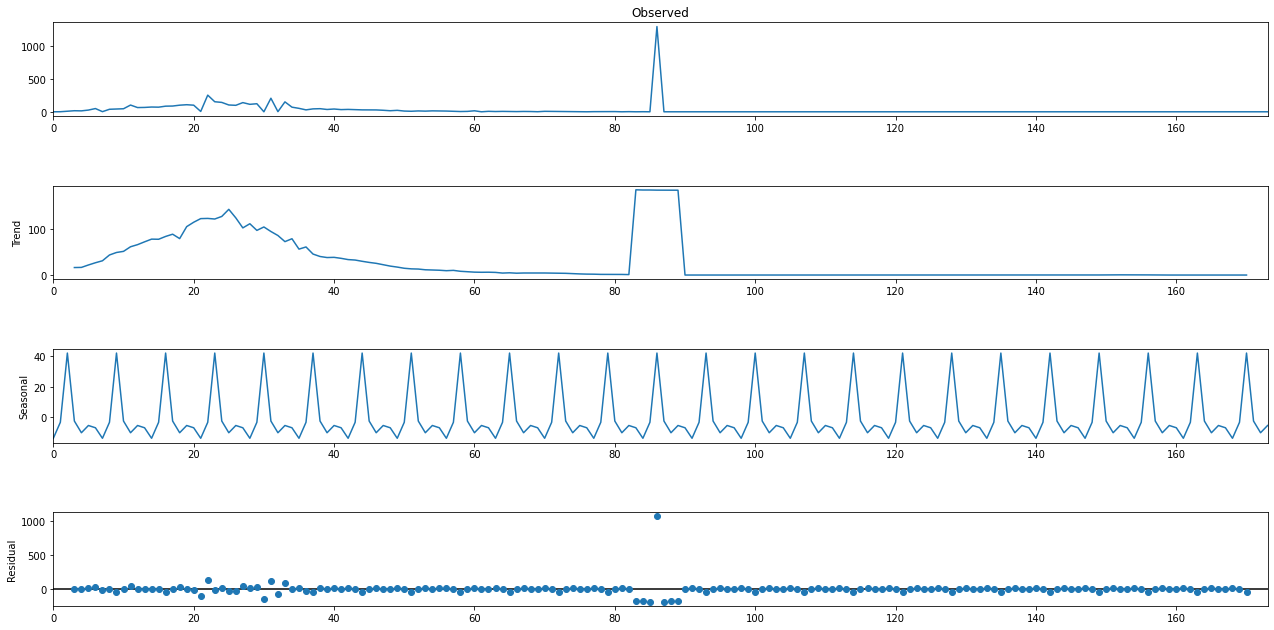

In [4]:
daily_increase_in_death_cases_china = daily_increase_in_death_cases[daily_increase_in_death_cases["Country/Region"]=="china"]
daily_increase_in_death_cases_china_values = daily_increase_in_death_cases_china.drop(daily_increase_in_death_cases_china.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_death_cases_china_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

**Seasonal Decomposition of increment in death cases in USA**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

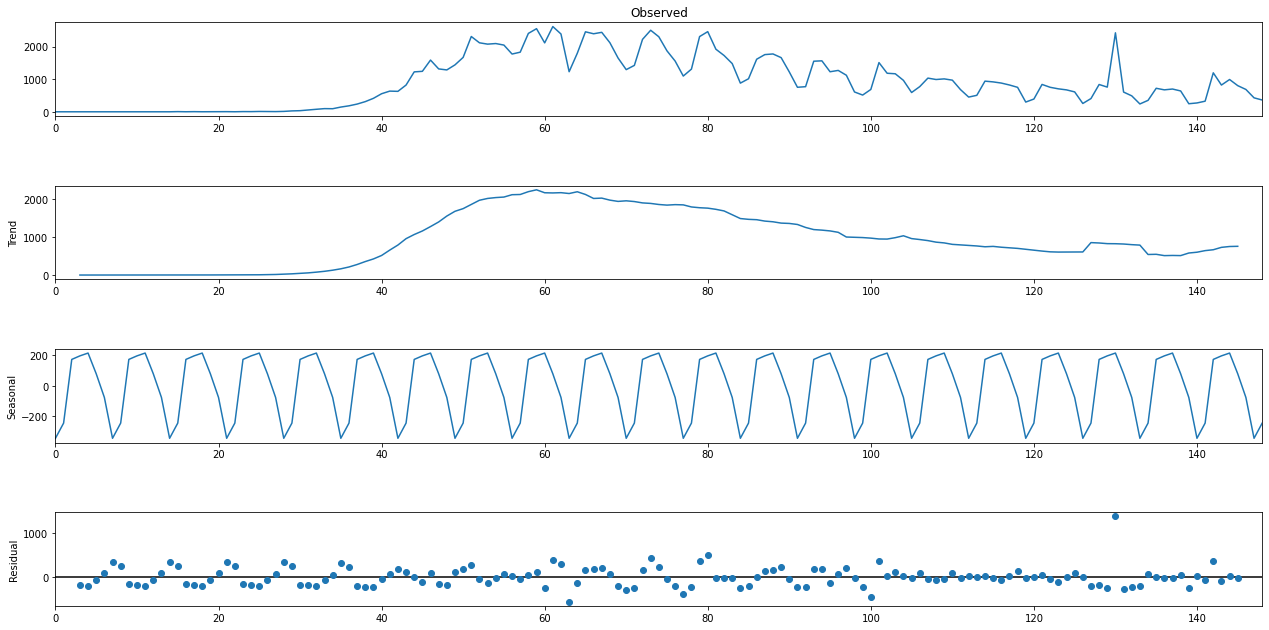

In [5]:
daily_increase_in_death_cases_usa = daily_increase_in_death_cases_after_16_feb[daily_increase_in_death_cases_after_16_feb["Country/Region"]=="us"]
daily_increase_in_death_cases_usa_values = daily_increase_in_death_cases_usa.drop(daily_increase_in_death_cases_usa.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_death_cases_usa_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

**Seasonal Decomposition of increment in death cases for India**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

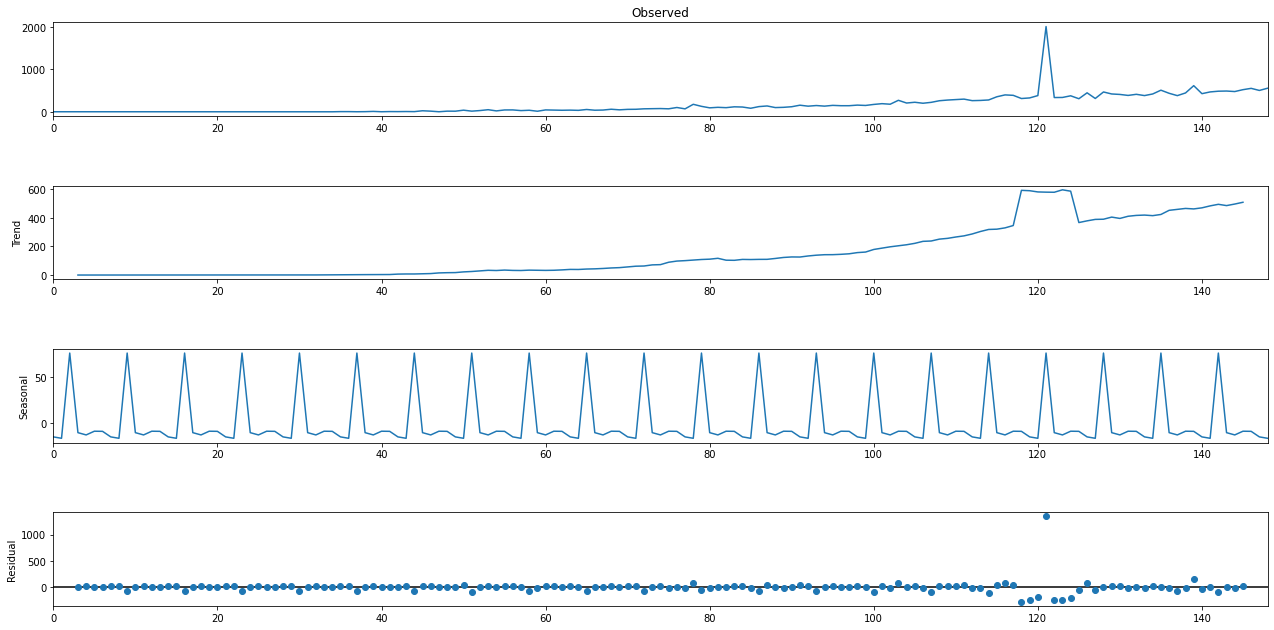

In [6]:
daily_increase_in_death_cases_india = daily_increase_in_death_cases_after_16_feb[daily_increase_in_death_cases_after_16_feb["Country/Region"]=="india"]
daily_increase_in_death_cases_india_values = daily_increase_in_death_cases_india.drop(daily_increase_in_death_cases_india.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_death_cases_india_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

**Seasonal Decomposition of increment in death cases for Brazil**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

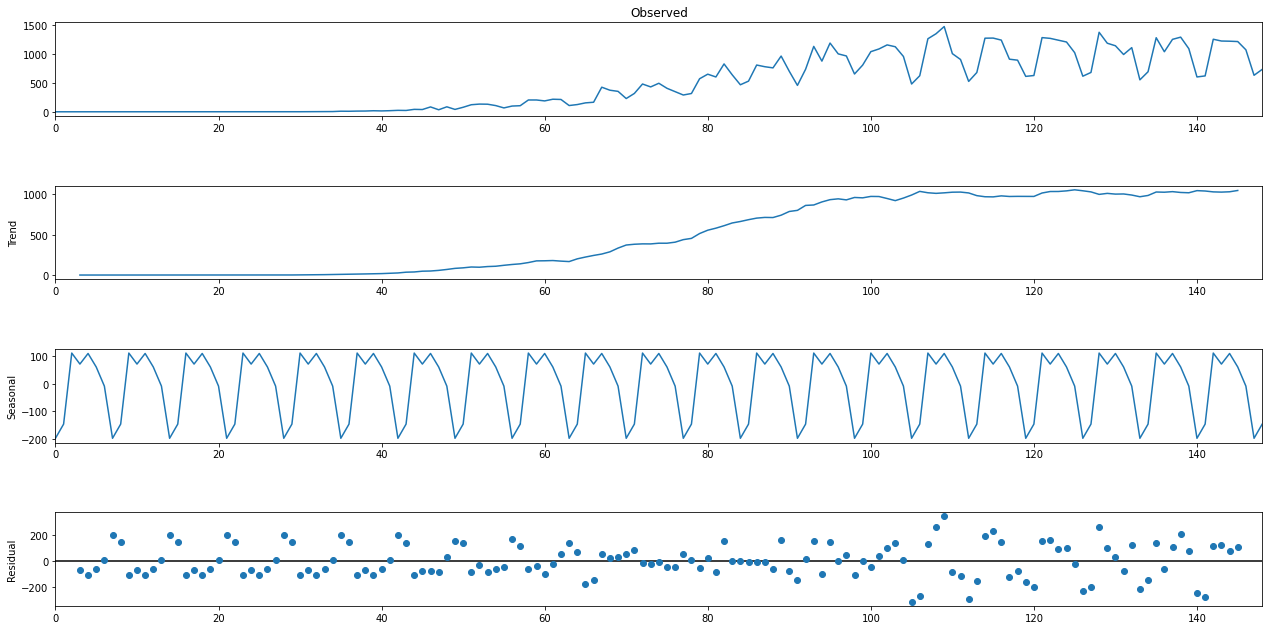

In [7]:
daily_increase_in_death_cases_brazil = daily_increase_in_death_cases_after_16_feb[daily_increase_in_death_cases_after_16_feb["Country/Region"]=="brazil"]
daily_increase_in_death_cases_brazil_values = daily_increase_in_death_cases_brazil.drop(daily_increase_in_death_cases_brazil.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_death_cases_brazil_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

# Building ARIMA model to predict increment in death country wise

In [11]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.9MB/s 
     |████████████████████████████████| 8.7MB 15.9MB/s 
     |████████████████████████████████| 2.1MB 41.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [8]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta

## 5.1 : Estimating the differencing term

country_model = {}
# print(countries)
for country in countries.values.ravel():
    print(country)
    data = daily_increase_in_death_cases[daily_increase_in_death_cases["Country/Region"]==country]
    data = data.drop(["Country/Region"]+last_7_days_for_forecasting, axis=1)
    if country!="china":
        data = data.drop(before_16_feb_columns, axis=1)
    data = data.values.ravel()
    kpss_diffs = ndiffs(data, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)

    model_auto = pm.auto_arima(data, start_p=1, start_q=1,
    #                     test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q 
                        m=1,              # frequency of series
                        d=n_diffs,        
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    country_model[country]=model_auto

afghanistan
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=897.782, BIC=909.577, Time=0.135 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=987.986, BIC=993.883, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=948.711, BIC=957.558, Time=0.044 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=897.325, BIC=906.171, Time=0.067 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=986.116, BIC=989.065, Time=0.013 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=896.871, BIC=908.666, Time=0.188 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=896.290, BIC=911.034, Time=0.258 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=897.889, BIC=915.581, Time=0.397 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=897.054, BIC=914.746, Time=0.460 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=895.168, BIC=909.912, Time=0.140 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True];

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=903.320, BIC=915.115, Time=0.097 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=921.941, BIC=927.838, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=912.173, BIC=921.019, Time=0.040 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=906.658, BIC=915.504, Time=0.073 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=920.258, BIC=923.207, Time=0.013 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=905.160, BIC=919.904, Time=0.141 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=905.142, BIC=919.886, Time=0.154 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=904.929, BIC=916.724, Time=0.072 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=909.042, BIC=920.837, Time=0.076 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=907.139, BIC=924.831, Time=0.220 seconds
Total fit time: 0.908 seconds
bosnia and herzegovina
Performing stepwise search to minimize aic
Fit

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=963.787, BIC=975.582, Time=0.248 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1061.836, BIC=1067.734, Time=0.023 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1022.919, BIC=1031.765, Time=0.047 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=962.275, BIC=971.121, Time=0.187 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1059.836, BIC=1062.785, Time=0.013 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=965.317, BIC=980.061, Time=0.384 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=966.146, BIC=980.890, Time=0.327 seconds
Near non-invertible roots for order (1, 1, 2)(0

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=914.258, BIC=920.155, Time=0.022 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=856.342, BIC=865.188, Time=0.046 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=828.274, BIC=837.120, Time=0.060 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=912.277, BIC=915.225, Time=0.013 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=828.680, BIC=840.475, Time=0.077 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=829.571, BIC=844.315, Time=0.129 seconds
Total fit time: 0.428 seconds
ecuador
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1532.012, BIC=1543.807, Time=0.106 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1610.511, BIC=1616.408, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1575.999, BIC=1584.845, Time=0.061 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1530.036, BIC=1538.882, Time=0.074 seconds
Fit ARIMA(

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=453.428, BIC=459.326, Time=0.016 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=400.420, BIC=409.266, Time=0.040 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=375.325, BIC=384.171, Time=0.064 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=451.428, BIC=454.377, Time=0.012 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=376.983, BIC=388.778, Time=0.077 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=378.783, BIC=393.527, Time=0.379 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.674 seconds
eswatini
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=119.680, BIC=131.475, Time=0.180 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=226.498, BIC=232.395, Time=0.040 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=T

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-3126.239, BIC=-3120.327, Time=0.100 seconds
Total fit time: 0.102 seconds
finland
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=790.079, BIC=801.874, Time=0.087 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=875.332, BIC=881.230, Time=0.015 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=799.097, BIC=807.944, Time=0.033 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=792.481, BIC=801.327, Time=0.048 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=873.332, BIC=876.281, Time=0.017 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=785.565, BIC=800.309, Time=0.113 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=794.594, BIC=806.389, Time=0.053 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=787.542, BIC=805.234, Time=0.155 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=787.550, BIC=805.242, Time=0.173 seconds
Fit ARIMA(1,1,

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=905.818, BIC=917.613, Time=0.093 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=970.888, BIC=976.785, Time=0.015 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=937.115, BIC=945.961, Time=0.043 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=903.864, BIC=912.711, Time=0.056 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=969.035, BIC=971.984, Time=0.014 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=905.810, BIC=917.605, Time=0.103 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=907.856, BIC=922.600, Time=0.100 seconds
Total fit time: 0.432 seconds
guinea
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=237.056, BIC=248.851, Time=0.343 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=331.111, BIC=337.008, Time=0.031 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=277.764, BIC=286.610, Time=0.041 seconds
Fit ARIMA(0,1,1)x(0

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-3126.239, BIC=-3120.327, Time=0.107 seconds
Total fit time: 0.108 seconds
honduras
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=921.622, BIC=933.417, Time=0.123 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=985.565, BIC=991.462, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=964.536, BIC=973.382, Time=0.047 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=921.344, BIC=930.190, Time=0.071 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=983.598, BIC=986.547, Time=0.018 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=921.349, BIC=933.144, Time=0.111 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=923.305, BIC=938.049, Time=0.177 seconds
Total fit time: 0.567 seconds
hungary
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=670.756, BIC=682.551, Time=0.064 seconds
Fit ARIMA(0,1,0)x(0,0,

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=245.372, BIC=257.195, Time=0.177 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=245.871, BIC=251.783, Time=0.039 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=246.981, BIC=255.849, Time=0.030 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=247.097, BIC=255.965, Time=0.039 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=262.328, BIC=265.284, Time=0.031 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=250.239, BIC=265.018, Time=0.064 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=250.238, BIC=265.017, Time=0.238 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=248.241, BIC=260.065, Time=0.063 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=248.239, BIC=260.063, Time=0.051 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=246.325, BIC=264.060, Time=0.504 seconds
Near non-invertible roots for order (2, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inver

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-3126.239, BIC=-3120.327, Time=0.102 seconds
Total fit time: 0.103 seconds
liberia
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=286.671, BIC=298.466, Time=0.160 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=381.369, BIC=387.266, Time=0.047 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=344.638, BIC=353.484, Time=0.056 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=285.719, BIC=294.565, Time=0.250 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=379.402, BIC=382.351, Time=0.013 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=286.440, BIC=298.235, Time=0.209 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=288.269, BIC=303.012, Time=0.416 seconds
Total fit time: 1.157 seconds
libya
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=337.549, BIC=349.344, Time=0.124 seconds
Fit ARIMA(0,1,0)x(0,0,0,0

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-3126.239, BIC=-3120.327, Time=0.292 seconds
Total fit time: 0.293 seconds
montenegro
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=86.451, BIC=98.246, Time=0.129 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=185.934, BIC=191.832, Time=0.056 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=125.450, BIC=134.297, Time=0.055 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=87.173, BIC=96.019, Time=0.136 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=183.934, BIC=186.883, Time=0.014 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=87.910, BIC=102.653, Time=0.193 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=88.066, BIC=102.809, Time=0.240 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=86.804, BIC=98.599, Time=0.116 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=113.385, BIC=125.180, Time=0.066 seconds
Fit ARIMA(2,1,2)x(0

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=167.368, BIC=179.163, Time=0.137 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=266.158, BIC=272.055, Time=0.032 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=228.758, BIC=237.604, Time=0.050 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=167.458, BIC=176.304, Time=0.087 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=264.177, BIC=267.125, Time=0.013 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=164.902, BIC=179.646, Time=0.178 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=210.911, BIC=222.706, Time=0.062 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=162.241, BIC=179.933, Time=0.215 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=192.334, BIC=207.078, Time=0.084 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=163.525, BIC=184.167, Time=0.357 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=160.631, BIC=181.273, Time=0.500 seconds
Fit ARIMA

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=149.061, BIC=160.884, Time=0.137 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=149.617, BIC=155.529, Time=0.061 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=148.963, BIC=157.830, Time=0.044 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=149.127, BIC=157.994, Time=0.173 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=163.901, BIC=166.857, Time=0.022 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=150.823, BIC=162.647, Time=0.110 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=151.009, BIC=165.788, Time=0.183 seconds
Total fit time: 0.734 seconds
peru
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1359.000, BIC=1370.795, Time=0.136 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1423.823, BIC=1429.720, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1406.441, BIC=1415.287, Time=0.057 seconds
Fit ARIMA(0,1,1

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-3126.239, BIC=-3120.327, Time=0.071 seconds
Total fit time: 0.071 seconds
saint vincent and the grenadines
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-3126.239, BIC=-3120.327, Time=0.070 seconds
Total fit time: 0.070 seconds
san marino
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=349.921, BIC=361.716, Time=0.105 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=443.196, BIC=449.093, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=390.213, BIC=399.059, Time=0.046 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=350.648, BIC=359.494, Time=0.101 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=441.196, BIC=444.145, Time=0.015 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=351.221, BIC=365.965, Time=0.111 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=347.224, BIC=361.968, Time=0.269 seconds
Near non-invertible roots for orde

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=365.064, BIC=376.859, Time=0.119 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=457.596, BIC=463.494, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=408.403, BIC=417.249, Time=0.037 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=365.511, BIC=374.357, Time=0.117 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=455.596, BIC=458.545, Time=0.012 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=366.833, BIC=381.577, Time=0.145 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=365.989, BIC=380.733, Time=0.235 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=364.658, BIC=376.453, Time=0.138 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=365.366, BIC=380.110, Time=0.158 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [int

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=112.912, BIC=124.735, Time=0.205 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=108.996, BIC=114.908, Time=0.046 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=110.920, BIC=119.788, Time=0.038 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=110.924, BIC=119.791, Time=0.240 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=119.361, BIC=122.317, Time=0.022 seconds
Total fit time: 0.555 seconds
trinidad and tobago
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.496, BIC=16.291, Time=0.119 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=97.301, BIC=103.198, Time=0.023 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=29.951, BIC=38.797, Time=0.069 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.016, BIC=17.862, Time=0.110 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=95.301, BIC=98.249, Time=0.016 seconds
Fit ARIMA(2,1,1)

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=793.085, BIC=804.880, Time=0.126 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=846.280, BIC=852.178, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=826.939, BIC=835.785, Time=0.036 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=794.896, BIC=803.743, Time=0.055 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=844.332, BIC=847.281, Time=0.012 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=794.830, BIC=809.574, Time=0.145 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=795.025, BIC=809.769, Time=0.211 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=793.233, BIC=805.028, Time=0.077 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=826.531, BIC=838.326, Time=0.057 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=787.783, BIC=805.476, Time=0.270 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=779.575, BIC=800.216, Time=0.296 seconds
Fit ARIMA

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=116.423, BIC=128.218, Time=0.119 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=181.120, BIC=187.017, Time=0.032 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=145.750, BIC=154.597, Time=0.058 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=117.193, BIC=126.040, Time=0.121 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=179.154, BIC=182.103, Time=0.014 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=109.785, BIC=124.529, Time=0.130 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=112.204, BIC=123.999, Time=0.103 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=111.753, BIC=129.446, Time=0.201 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=102.946, BIC=120.639, Time=0.269 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=103.978, BIC=118.722, Time=0.293 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=104.773, BIC=125.414, Time=0.419 seconds
Fit ARIMA

**Predictions of increment in daily death cases**

In [16]:
prediction_countries = ["india", "brazil"]
for country in prediction_countries:
    print("Predicted Increment in daily death cases in {} for next 7 days are: {}".format(country.upper(), country_model[country].predict(7, alpha=0.05).tolist()))

print("----------------------------------------------------------")
for country in prediction_countries:
    actual_increment = daily_increase_in_death_cases[daily_increase_in_death_cases["Country/Region"]==country].iloc[:,168:175].values.ravel().tolist()
    print("Actual Increment in daily death cases in {} for next 7 days are: {}".format(country.upper(), actual_increment))

Predicted Increment in daily death cases in INDIA for next 7 days are: [475.8112095345959, 479.3563041124891, 482.90139869038234, 486.44649326827556, 489.9915878461688, 493.536682424062, 497.08177700195523]
Predicted Increment in daily death cases in BRAZIL for next 7 days are: [1055.9100499430956, 1153.885213464214, 1188.246124697101, 1329.2665344776603, 1138.422432926266, 711.1568035120805, 765.5733957916303]
----------------------------------------------------------
Actual Increment in daily death cases in INDIA for next 7 days are: [483.0, 487.0, 475.0, 519.0, 550.0, 501.0, 553.0]
Actual Increment in daily death cases in BRAZIL for next 7 days are: [1254.0, 1223.0, 1220.0, 1214.0, 1071.0, 631.0, 733.0]


# Predicting the increment in death cases world_wide

**Algo:**

1. initialize world_total_death_cases = 0

2. for every country predict the increment in death cases

    >new_death_cases_for_the_country = increment in death cases + death cases on previous day for that country.

    >world_total_death_cases = world_total_death_cases + new_death_cases_for_the_country

# Future Steps/Improvemebts

Since We have inadequate data to predict the confirm cases

it would be better if we can have 
1. daily basis hospital data, 
2. daily basis lockdown period data,
3. daily basis people tracedown data
4. travel history data
5. Persons Health data